Connection with google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# setup

In [2]:
!pip3 install fuzzywuzzy python-Levenshtein
!pip3 install dtreeviz             # install dtreeviz for sklearn
!pip3 install dtreeviz[xgboost]    # install XGBoost related dependency
!pip3 install dtreeviz[pyspark]    # install pyspark related dependency
!pip3 install dtreeviz[lightgbm]   # install LightGBM related dependency


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 7.4 MB/s 
     |████████████████████████████████| 2.2 MB 51.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 886 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=92b69e43ae56f0fc88c4fe6fccdc8aa9107cfecff64cbea0db0627093a052af1
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 53.9 MB/s 
  Created wheel for pyspark:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.tree as sktree
import sklearn.metrics as skmetrics
import sklearn.model_selection as skmodelselect
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
import sklearn.metrics as skmetrics
import graphviz
import pydotplus
from IPython.display import display
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from dtreeviz.trees import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams.update({
    'font.size': 16,
    'font.family': 'serif',
    'figure.figsize': (13, 8)
})

pd.set_option('display.max_colwidth', 200)

# Loading data from Lattes Curriculum

In [5]:
{
    "tags": [
        "hide-output"
    ]
}

{'tags': ['hide-output']}

In [ ]:
df_pesq = pd.read_excel('drive/MyDrive/Dados base pesquisa/1_importação currículo lattes/DadosImportadosDosCurriculos_451 registros.xlsx')
#df_pesq.columns = df_pesq.columns.str.strip()
df_pesq

## Loading data from questionary asked to researchers by google forms

In [ ]:
df_rel = pd.read_excel('drive/MyDrive/Dados base pesquisa/1_importação currículo lattes/Inventores_universidade 451.xlsx', usecols='B,C,E')
df_rel.rename(columns = {'Patentes':'Patentes e registros atualizado','Instituição':'Universidade Atuação','Instituição':'Nome'},inplace = True)
df_rel['Lattes'] = df_rel['Lattes'].str.strip()
df_rel


# Merging the Lattes table dataframe and the patents with updated profiles

In [ ]:
if (df_rel.Lattes.value_counts() > 1).any():
    print('Temos duplicados! Vamos descartar as cópias com menos patentes.')
    df_rel.sort_values('Patentes e registros atualizado', inplace=True)
    df_rel.drop_duplicates('Lattes', keep='last', inplace=True)

if not set(df_rel.Lattes).symmetric_difference(set(df_pesq.Lattes)):
    print('Conjunto de ids Lattes idênticos')

df_pesq = df_pesq.merge(df_rel, how = 'inner', on='Lattes')

df_pesq.rename(columns = {'Nome_x':'Nome'},inplace = True)

df_pesq.drop(columns = ['Nome_y','Data última atualização'],inplace= True)

df_pesq

In [ ]:
df_perfil = pd.read_excel('drive/MyDrive/Dados base pesquisa/2_dados questionário on line/Revisado_PERFIL INVENTORES_Likert  140 respostas.xlsx')

df_perfil.rename(columns ={'Informe seu nome completo':'Nome', 'Unnamed: 2':'Nome'},inplace = True)

df_perfil.drop(columns = ['Unnamed: 0', 'Atenção!', 'Campo livre para, se desejar, complementar sua opinião, compartilhar impressões, sugestões e/ou dúvidas.'], inplace = True)

df_perfil.columns = df_perfil.columns.str.strip()

df_perfil


# Associating each of researcher's name to a name in Lattes dataframe ordered by match_score

In [6]:
df_perfil[['match_name', 'match_score']] = pd.DataFrame(df_perfil["Nome"].apply(lambda x: process.extractOne(x, df_pesq["Nome"].to_list(),scorer = fuzz.token_sort_ratio)).to_list())

df_perfil[['Nome', 'match_name', 'match_score']].sort_values('match_score')[:15]

NameError: ignored


### Cleaning mismatching entries in dataframes

In [ ]:
df_perfil.drop([63, 121, 37, 62, 59, 80], inplace=True)

df_perfil[['Nome', 'match_name', 'match_score']].sort_values('match_score')[:15]


### Searching for researcher's that have eventualy answered more than once the questionary

In [ ]:
df_perfil[df_perfil['match_name'].map(df_perfil['match_name'].value_counts() > 1)].sort_values('Nome')

In [ ]:
df_perfil

In [ ]:
df_perfil.drop_duplicates('match_name', keep='last', inplace=True)

df_pesq = df_perfil.merge(df_pesq, left_on='match_name', right_on='Nome')
df_pesq.rename(columns = {'Nome_x':'Nome'},inplace = True)
df_pesq.drop(columns = ['Nome_y'], inplace = True)
df_pesq

In [ ]:
df_pesq[df_pesq['Ano de nascimento'].isna()]

In [ ]:
df_pesq.isna().sum().sort_values(ascending=False)

Linhas de pesquisa                                                                                                                             20
Mestrado                                                                                                                                       13
Atuação Profissional                                                                                                                            4
Áreas de atuação                                                                                                                                4
Graduação                                                                                                                                       2
Doutorado                                                                                                                                       1
Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares                                    

In [ ]:
df_pesq['Ano de nascimento'].astype(str).map(type).value_counts()

<class 'str'>    131
Name: Ano de nascimento, dtype: int64

# Gráfico de Barras do atributo alvo "Orientação Profissional"
# Barplot of "Orientação Profissional"

In [ ]:
df_labels = pd.read_excel('drive/MyDrive/Dados base pesquisa/2_dados questionário on line/Indicador aferição perfil do pesquisador.xlsx',usecols = 'A,B,C',index_col = 0)
df_labels.index = df_labels.index.str.strip()
df_labels


,Resultados Esperados,Natureza da Motivação
Fatores que motivam a patentear,,
"Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas",Econômico,Externo
"Apoio administrativo institucional no processo de patenteamento, principalmente do Núcleo de Inovação Tecnológica (NIT) da sua universidade",Reputação,Intrínseca
Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis,Reputação,Externo
Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa,Econômico,Externo
Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares,Reputação,Externo
Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.,Reputação,Externo
Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa,Econômico,Externo
Competição e colaboração entre os pares na formação de redes pessoais e profissionais,Reputação,Externo
Contribuição da promoção e/ou progressão na carreira com impacto na remuneração,Econômico,Externo


Hybrid : Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.
Entrepreneurial : Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.
Pragmatic traditional : Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.
Pure Traditional : Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.


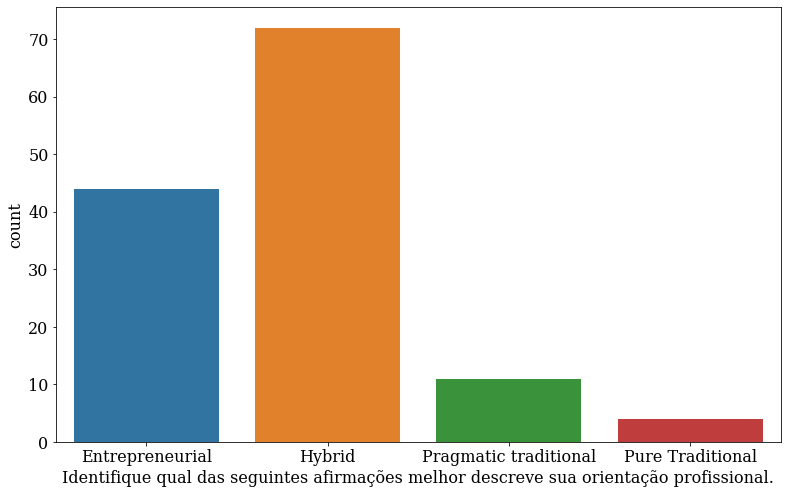

In [ ]:
dict_labels = {'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.':'Hybrid','Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.':'Entrepreneurial','Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.':'Pragmatic traditional','Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.':'Pure Traditional'}

for k in dict_labels:
    print(dict_labels[k], ':', k)

_ = sns.countplot(x=df_pesq['Identifique qual das seguintes afirmações melhor descreve sua orientação profissional.'].replace(dict_labels).sort_values())
# o_ foi pra sumir com o warning chato


### Manually fix of inconsistent data

In [ ]:
df_pesq['Ano de nascimento'] = df_pesq['Ano de nascimento'].astype(str).str.split('/').str[-1].str.strip()
df_pesq['Ano de nascimento'] = df_pesq['Ano de nascimento'].astype(str).str.split(' ').str[-1].str.strip()
df_pesq['Ano de nascimento'] = pd.to_numeric(df_pesq['Ano de nascimento'])

df_pesq['Ano de nascimento'] = df_pesq['Ano de nascimento'].replace(to_replace = 3061959,value = 1959)

# Graph of gender label 
## Blue - men
## Orange - women

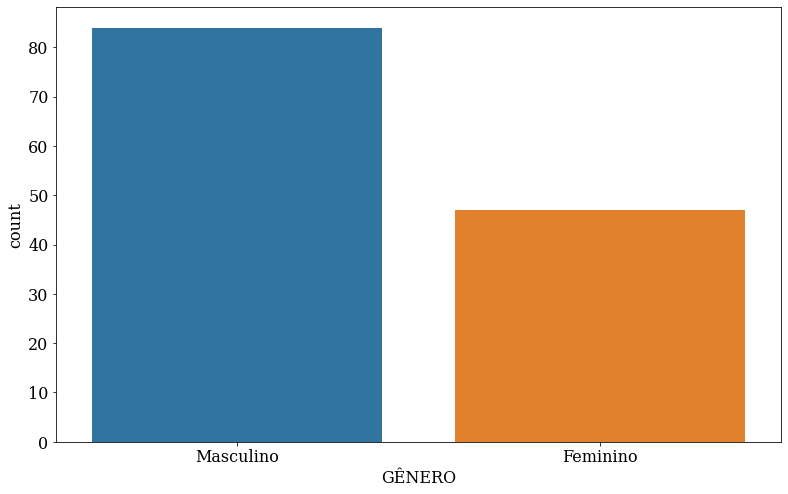

In [ ]:
_ = sns.countplot(x = df_pesq['GÊNERO'])

# Researcher's year of birth distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


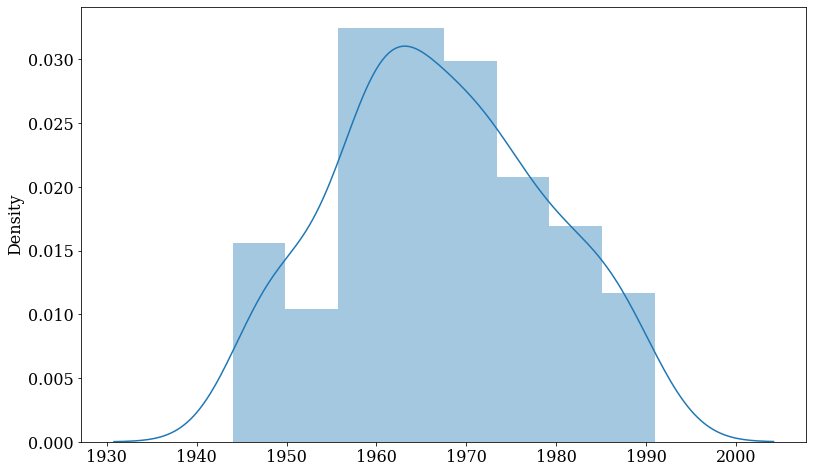

In [ ]:
_ = sns.distplot(x = df_pesq['Ano de nascimento'])


# Histograms in general

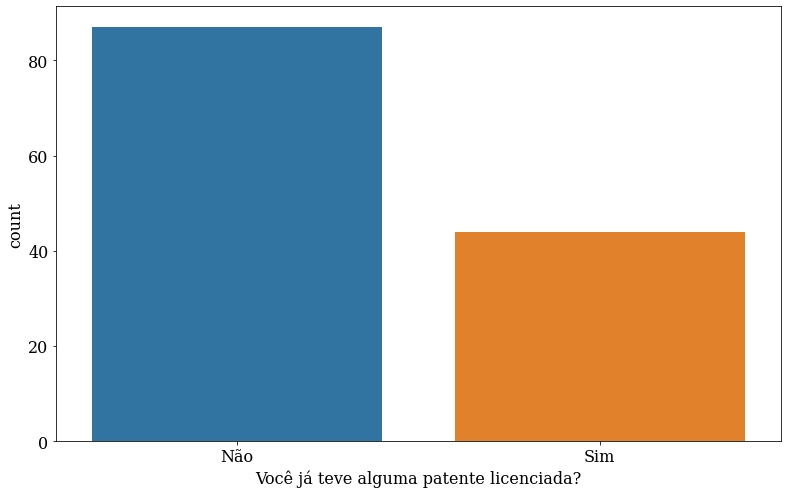

In [ ]:
_ = sns.countplot(x = df_pesq['Você já teve alguma patente licenciada?'].sort_values())

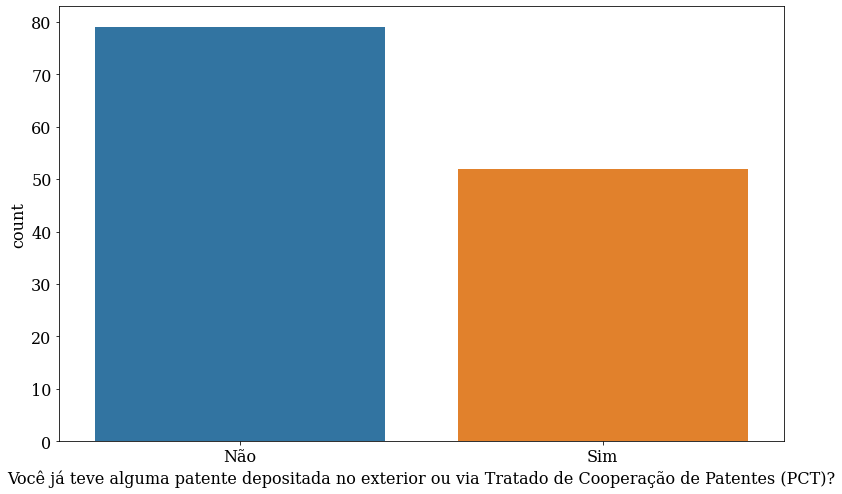

In [ ]:
_ = sns.countplot(x = df_pesq['Você já teve alguma patente depositada no exterior ou via Tratado de Cooperação de Patentes (PCT)?'].sort_values())


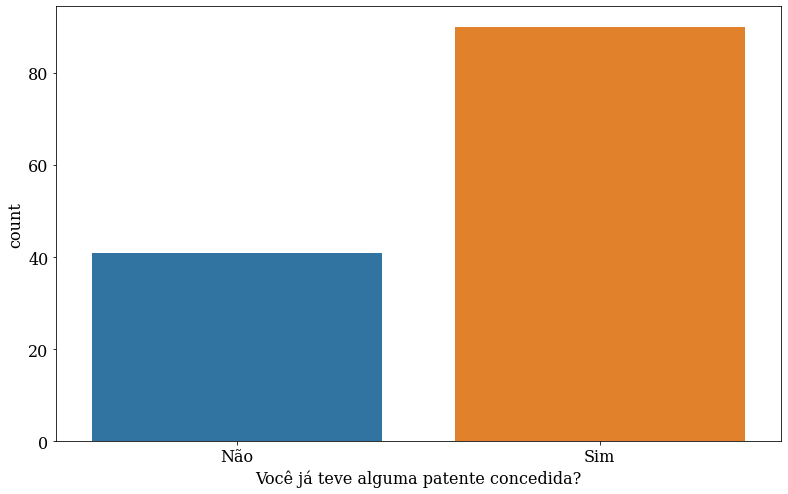

In [ ]:
_ = sns.countplot(x = df_pesq['Você já teve alguma patente concedida?'].sort_values())

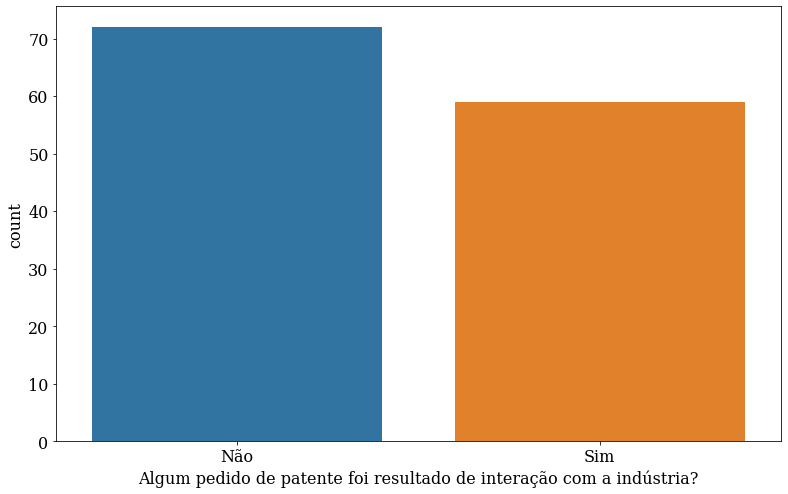

In [ ]:
_ = sns.countplot(x = df_pesq['Algum pedido de patente foi resultado de interação com a indústria?'].sort_values())

Fazendo a conversão dos dados da coluna 'Algum pedido de patente foi resultado de interação com a indústria?' para 'Ativo' e 'Passivo'.

In [ ]:
df_pesq['Ativo ou passivo'] = df_pesq['Algum pedido de patente foi resultado de interação com a indústria?'].replace(('Não','Sim'),('Passivo','Ativo'))

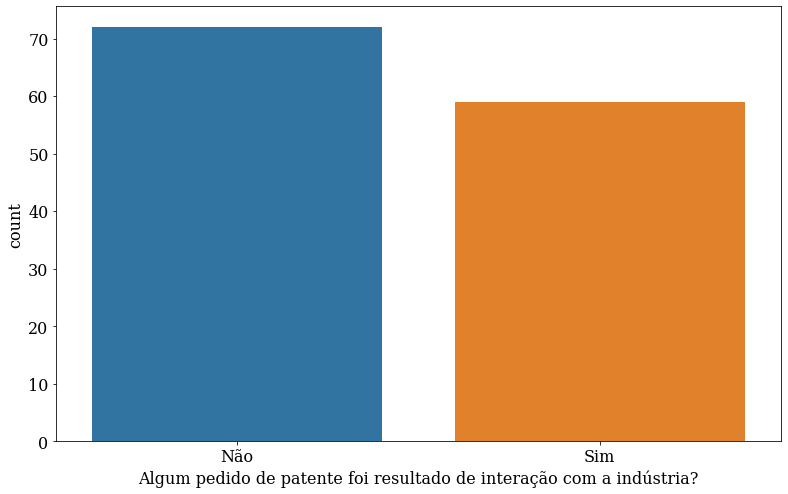

In [ ]:
_ = sns.countplot(x = df_pesq['Algum pedido de patente foi resultado de interação com a indústria?'].sort_values())

Não vale a pena fazer o gráfico sobre ocasional ou recorrente visto que todos os valores são maiores ou iguais a 3

It is not worth it to make "ocasional ou recorrente" since all of values are greater or equal to 3.

In [ ]:
#ocasional ou recorrete 

df_pesq['Ocasional ou recorrente'] = df_pesq['Patentes e registros atualizado'] >= 3

#df_pesq['Ocasional ou recorrete'].replace((True,False),("Maior que 3","Menor que"))

In [ ]:
df_pesq['Ocasional ou recorrente'] = np.where(df_pesq['Ocasional ou recorrente'],'Ocasional','Recorrente')


In [ ]:
df_pesq['Ocasional ou recorrente'].value_counts()

Ocasional    131
Name: Ocasional ou recorrente, dtype: int64

In [ ]:
df_numericos = df_pesq[df_labels.index]


# Ranking sortable data

In [ ]:
df_numericos.shape

(131, 27)

In [ ]:
df_dados = pd.DataFrame({'media':df_numericos.mean(), 'desvio_padrao': df_numericos.std()}).sort_values('media', ascending=False)
df_dados


,media,desvio_padrao
Contribuição dos resultados da pesquisa para o desenvolvimento social e econômico da sociedade,4.793893,0.491740
"Gosto por desafios, resolução de problemas de pesquisa e curiosidade intelectual",4.687023,0.595935
Potencial de aplicação dos resultados da pesquisa,4.679389,0.544443
Satisfação pessoal e realização profissional na realização da pesquisa,4.671756,0.560806
Obtenção de financiamentos e recursos para a pesquisa,4.603053,0.791098
Qualificação e competência pessoal para o desenvolvimento da pesquisa,4.549618,0.670404
Instalações e condições infraestruturais para o desenvolvimento da pesquisa disponíveis na sua instituição,4.541985,0.834446
"Apoio administrativo institucional no processo de patenteamento, principalmente do Núcleo de Inovação Tecnológica (NIT) da sua universidade",4.412214,1.044180
"Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas",4.389313,1.041984
Independência e autonomia no desenvolvimento da pesquisa,4.358779,0.794875


In [ ]:
df_dados.shape

(27, 2)

In [ ]:
df_relacional = pd.merge(df_labels,df_dados,left_index = True,right_index=True)
df_relacional.shape

(27, 4)

In [ ]:
df_relacional

,Resultados Esperados,Natureza da Motivação,media,desvio_padrao
"Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas",Econômico,Externo,4.389313,1.041984
"Apoio administrativo institucional no processo de patenteamento, principalmente do Núcleo de Inovação Tecnológica (NIT) da sua universidade",Reputação,Intrínseca,4.412214,1.044180
Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis,Reputação,Externo,4.206107,0.909079
Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa,Econômico,Externo,3.152672,1.303683
Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares,Reputação,Externo,3.580153,1.143236
Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.,Reputação,Externo,2.786260,1.095499
Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa,Econômico,Externo,4.053435,0.922480
Competição e colaboração entre os pares na formação de redes pessoais e profissionais,Reputação,Externo,3.297710,1.161529
Contribuição da promoção e/ou progressão na carreira com impacto na remuneração,Econômico,Externo,3.404580,1.194723
Contribuição dos resultados da pesquisa para o desenvolvimento social e econômico da sociedade,Desafio,Misto,4.793893,0.491740


In [ ]:
df_relacional[df_relacional['Resultados Esperados'] == 'Econômico']

,Resultados Esperados,Natureza da Motivação,media,desvio_padrao
"Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas",Econômico,Externo,4.389313,1.041984
Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa,Econômico,Externo,3.152672,1.303683
Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa,Econômico,Externo,4.053435,0.922480
Contribuição da promoção e/ou progressão na carreira com impacto na remuneração,Econômico,Externo,3.404580,1.194723
Habilidade para finanças e realização de negócios,Econômico,Externo,3.038168,1.179339
Licenciamento e Comercialização dos resultados da pesquisa,Econômico,Externo,4.190840,0.953653
Momento profissional da carreira acadêmica ou de pesquisador,Econômico,Externo,3.877863,0.984674
Obtenção de financiamentos e recursos para a pesquisa,Econômico,Externo,4.603053,0.791098
Qualificação e competência pessoal para o desenvolvimento da pesquisa,Econômico,Externo,4.549618,0.670404


In [ ]:
data_relacional = df_relacional['media'].groupby(df_relacional['Resultados Esperados'])

data_relacional = pd.DataFrame(data_relacional.mean())

data_relacional


,media
Resultados Esperados,
Desafio,4.496183
Econômico,3.917727
Reputação,3.741306


In [ ]:
data_relacional['Resultados Esperados'] = data_relacional.index
data_relacional

,media,Resultados Esperados
Resultados Esperados,,
Desafio,4.496183,Desafio
Econômico,3.917727,Econômico
Reputação,3.741306,Reputação


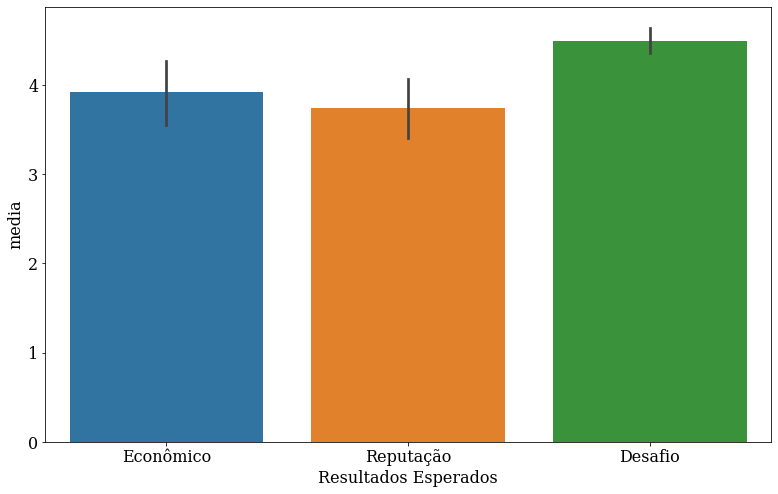

In [ ]:
#relacional_list= ['Desafio','Econômico','Reputação']

sns.barplot( y = 'media', x ='Resultados Esperados',data = df_relacional)

In [ ]:
data_motivacao = df_relacional['media'].groupby(df_relacional['Natureza da Motivação'])
data_motivacao = pd.DataFrame(data_motivacao.mean())

data_motivacao.rename(index ={'Externo':'Extrínseca'},inplace = True)
data_motivacao

,media
Natureza da Motivação,
Extrínseca,3.795240
Intrínseca,4.412214
Misto,4.496183


In [ ]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})

In [ ]:
data_motivacao['Natureza da Motivação'] = data_motivacao.index
#data_motivacao.rename(columns = {'Externo':'Extrínseca'},inplace = True)
data_motivacao

,media,Natureza da Motivação
Natureza da Motivação,,
Extrínseca,3.795240,Extrínseca
Intrínseca,4.412214,Intrínseca
Misto,4.496183,Misto


In [ ]:
type(data_motivacao)

pandas.core.frame.DataFrame

In [ ]:
data_motivacao

,media,Natureza da Motivação
Natureza da Motivação,,
Extrínseca,3.795240,Extrínseca
Intrínseca,4.412214,Intrínseca
Misto,4.496183,Misto


In [ ]:
#df['is_blue'] = df['is_blue'].apply(lambda x: 'Yes' if (x == 1) else 'No') 
#>>> df.rename({1: 2, 2: 4}, axis='index')

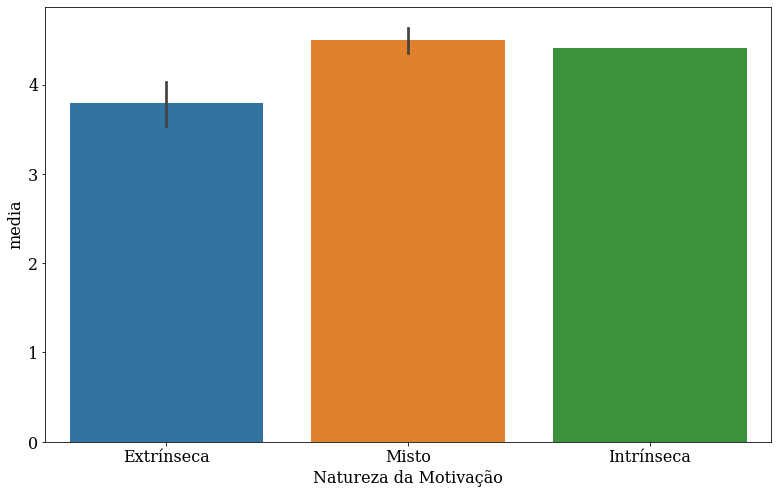

In [ ]:
#motivacional_list = ['Extrínseca','Misto','Intrínseca']
#g.set(xticklabels=["first", "second", "third"])
motivacional = sns.barplot(y = 'media',x ='Natureza da Motivação',data = df_relacional,order = ['Externo','Misto','Intrínseca'])
motivacional.set(xticklabels = ['Extrínseca','Misto','Intrínseca'])
plt.savefig("GraficoNmotivacaoFINAL3.png")

A coluna 'Intrínseca' não possui desvio padrão visto que só existe um valor dessa classe.

Column named "Intrínseca" does not have standard deviation because there is only one class

In [ ]:
dados_dp_natureza_motiv = df_relacional['desvio_padrao'].groupby(df_relacional['Natureza da Motivação'])
dados_dp_natureza_motiv = pd.DataFrame(dados_dp_natureza_motiv.mean())
#externo = 1.04, intrinseca= 1.044, misto = 0.72
dados_dp_natureza_motiv


,desvio_padrao
Natureza da Motivação,
Externo,1.040922
Intrínseca,1.044180
Misto,0.722848


In [ ]:
dados_dp_natureza_re = df_relacional['desvio_padrao'].groupby(df_relacional['Resultados Esperados'])
dados_dp_natureza_re = pd.DataFrame(dados_dp_natureza_re.mean())
#externo = 1.04, intrinseca= 1.044, misto = 0.72
dados_dp_natureza_re

,desvio_padrao
Resultados Esperados,
Desafio,0.722848
Econômico,1.004671
Reputação,1.077535


In [ ]:
data_motivacao

,media,Natureza da Motivação
Natureza da Motivação,,
Extrínseca,3.795240,Extrínseca
Intrínseca,4.412214,Intrínseca
Misto,4.496183,Misto


In [ ]:
df_relacional[df_relacional['Natureza da Motivação'] == 'Externo'].index

Index(['Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas',
       'Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis',
       'Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa',
       'Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares',
       'Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.',
       'Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa',
       'Competição e colaboração entre os pares na formação de redes pessoais e profissionais',
       'Contribuição da promoção e/ou progressão na carreira com impacto na remuneração',
       'Disponibilidade de materiais, dados e recursos oriundos da indústria para o desenvolvimento das atividades de pesquisa',
       'Habilidade para finanças e realiza

In [ ]:
df_pesq_class_externo = df_pesq[['Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas',
       'Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis',
       'Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa',
       'Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares',
       'Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.',
       'Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa',
       'Competição e colaboração entre os pares na formação de redes pessoais e profissionais',
       'Contribuição da promoção e/ou progressão na carreira com impacto na remuneração',
       'Disponibilidade de materiais, dados e recursos oriundos da indústria para o desenvolvimento das atividades de pesquisa',
       'Habilidade para finanças e realização de negócios',
       'Influência de colaboradores e parceiros estrangeiros',
       'Licenciamento e Comercialização dos resultados da pesquisa',
       'Momento profissional da carreira acadêmica ou de pesquisador',
       'Obtenção de financiamentos e recursos para a pesquisa',
       'Participação em viagens e/ou experiências em outros lugares/culturas como influência para o desenvolvimento de pesquisas',
       'Qualificação e competência pessoal para o desenvolvimento da pesquisa',
       'Relações e cooperação de mercado com a indústria, inclusive com atração de recursos financeiros']]
       

In [ ]:
df_relacional[df_relacional['Natureza da Motivação'] == 'Misto'].index

Index(['Contribuição dos resultados da pesquisa para o desenvolvimento social e econômico da sociedade',
       'Experiência profissional anterior como acadêmico e pesquisador',
       'Gosto por desafios, resolução de problemas de pesquisa e curiosidade intelectual',
       'Independência e autonomia no desenvolvimento da pesquisa',
       'Influência de membros do grupo de pesquisa por meio de troca de experiências',
       'Instalações e condições infraestruturais para o desenvolvimento da pesquisa disponíveis na sua instituição',
       'Potencial de aplicação dos resultados da pesquisa',
       'Proteção e apropriação intelectual dos resultados da pesquisa',
       'Satisfação pessoal e realização profissional na realização da pesquisa'],
      dtype='object')

In [ ]:
df_pesq_class_Misto = df_pesq[['Contribuição dos resultados da pesquisa para o desenvolvimento social e econômico da sociedade',
       'Experiência profissional anterior como acadêmico e pesquisador',
       'Gosto por desafios, resolução de problemas de pesquisa e curiosidade intelectual',
       'Independência e autonomia no desenvolvimento da pesquisa',
       'Influência de membros do grupo de pesquisa por meio de troca de experiências',
       'Instalações e condições infraestruturais para o desenvolvimento da pesquisa disponíveis na sua instituição',
       'Potencial de aplicação dos resultados da pesquisa',
       'Proteção e apropriação intelectual dos resultados da pesquisa',
       'Satisfação pessoal e realização profissional na realização da pesquisa']]

In [ ]:
df_pesq_class_Misto.mean(1) #fazendo media por linha

0      4.777778
1      4.888889
2      4.555556
3      4.111111
4      4.777778
         ...   
126    4.000000
127    4.000000
128    4.111111
129    4.888889
130    4.666667
Length: 131, dtype: float64

In [ ]:
df_relacional[df_relacional['Natureza da Motivação'] == 'Externo'].index

Index(['Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas',
       'Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis',
       'Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa',
       'Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares',
       'Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.',
       'Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa',
       'Competição e colaboração entre os pares na formação de redes pessoais e profissionais',
       'Contribuição da promoção e/ou progressão na carreira com impacto na remuneração',
       'Disponibilidade de materiais, dados e recursos oriundos da indústria para o desenvolvimento das atividades de pesquisa',
       'Habilidade para finanças e realiza

In [ ]:
print('Media externo, intrinseco, misto')
media_class_externa = round(data_motivacao['media'][0],3)
media_class_intrinseca = round(data_motivacao['media'][1],3)
media_class_misto = round(data_motivacao['media'][2],3)

print(media_class_externa,media_class_intrinseca,media_class_misto)


Media externo, intrinseco, misto
3.795 4.412 4.496


In [ ]:
vec_medias_motiv = np.array([data_motivacao['media'][0],data_motivacao['media'][1], data_motivacao['media'][2]])

In [ ]:
print('Media desafio, economico, reputacao')
media_class_desafio= data_relacional['media'][0]
media_class_economico = data_relacional['media'][1]
media_class_reputacao = data_relacional['media'][2]
#fazer apenas o print com %f nao com round
print(media_class_desafio,media_class_economico,media_class_reputacao)


Media desafio, economico, reputacao
4.49618320610687 3.9177268871925355 3.7413061916878707


In [ ]:
np.arange(20).reshape((4,-1)).mean(1)

array([ 2.,  7., 12., 17.])

In [ ]:
data_motivacao

,media,Natureza da Motivação
Natureza da Motivação,,
Extrínseca,3.795240,Extrínseca
Intrínseca,4.412214,Intrínseca
Misto,4.496183,Misto


In [ ]:
data_relacional

,media,Resultados Esperados
Resultados Esperados,,
Desafio,4.496183,Desafio
Econômico,3.917727,Econômico
Reputação,3.741306,Reputação


In [ ]:
df_pesq['Media_Externo'] = df_pesq[df_relacional[df_relacional['Natureza da Motivação'] == 'Externo'].index].mean(1)
df_pesq['Media_Intrínseca'] = df_pesq[df_relacional[df_relacional['Natureza da Motivação'] == 'Intrínseca'].index].mean(1)
df_pesq['Media_Misto'] = df_pesq[df_relacional[df_relacional['Natureza da Motivação']== 'Misto'].index].mean(1)
############################ Agora para o resultados esperados ##################################
df_pesq['Media_Desafio'] = df_pesq[df_relacional[df_relacional['Resultados Esperados']== 'Desafio'].index].mean(1)
df_pesq['Media_Econômico'] = df_pesq[df_relacional[df_relacional['Resultados Esperados']== 'Econômico'].index].mean(1)
df_pesq['Media_Reputação'] = df_pesq[df_relacional[df_relacional['Resultados Esperados']== 'Reputação'].index].mean(1)



In [ ]:
df_pesq

In [ ]:
df_pesq.shape

(131, 60)

# Exercício de classificação tendo como alvo as respostas dos pesquisadores(as) a afirmação que melhor descreve a orientação profissional:

# Training a classifier having researcher's answer that best fits its professional profile using Decision Tree Classifier

In [ ]:
def plotar_feature_im(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_,align = 'center')
    plt.yticks(np.arange(n_features),X)
    plt.xlabel("Grau de relevância")
    plt.ylabel("Colunas")
    plt.ylim(-1,n_features)

def plot_tree(my_tree, columns):
    export_graphviz(my_tree, out_file = "my_tree.pdf", feature_names = columns, filled = True)
    with open("my_tree.pdf") as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
    

In [ ]:
#Nosso alvo vai ser o df_pesq['Identifique qual das seguintes afirmações melhor descreve sua orientação profissional.']
y = df_pesq['Identifique qual das seguintes afirmações melhor descreve sua orientação profissional.']

X = df_numericos

#dtc = DecisionTreeClassifier(criterion='gini', max_depth=3, class_weight=(1/y.value_counts()).to_dict()).fit(X, y)
#dtc = DecisionTreeClassifier(criterion='entropy', min_samples_split=20).fit(X, y)
#dtc = DecisionTreeClassifier().fit(X, y)

In [ ]:
np.linspace(0,0.4,3)
np.arange(2,33,10)

array([ 2, 12, 22, 32])

In [ ]:
y.value_counts()

Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.                                                72
Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.                                         44
Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.    11
Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.                                                         4
Name: Identifique qual das seguintes afirmações melhor descreve sua orientação profissional., dtype: int64

In [ ]:
y.value_counts().min()

4

In [ ]:
%%time

param_dict = {
        "criterion":[ 'gini','entropy'],
        "max_depth":np.arange(1,12,2),
        "min_samples_leaf":np.arange(1,6,2),
        "min_samples_split":np.arange(2,8,2),
        'min_weight_fraction_leaf': np.linspace(0,0.4,3),
        'max_leaf_nodes': np.arange(2,33,10),
        'min_impurity_decrease': np.linspace(.1,.3,3),
        'ccp_alpha': np.linspace(0,0.2,3),
        #'class_weight': [(1/y.value_counts()).to_dict(), None],
        
}

param_dict = {
        "criterion":[ 'gini','entropy' ],
        "max_depth":np.arange(1,11),
        "min_samples_leaf":np.arange(1,6),
        "min_samples_split":np.arange(2,7),
        #'class_weight': [(1/y.value_counts()).to_dict(), None], aqui foi doidera viajei

        
}

scoring_opts = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro', 'precision_micro', 'recall_micro', 'precision_macro', 'recall_macro']

grid = skmodelselect.GridSearchCV(sktree.DecisionTreeClassifier(),
                   param_grid = param_dict,
                   #cv = skmodelselect.StratifiedShuffleSplit(100, .18),
                   #cv = (KFold(len(df_pesq))),
                   cv = skmodelselect.RepeatedStratifiedKFold(n_splits = y.value_counts().min(),n_repeats = 200),
                   #cv = skmodelselect.LeavePOut(1),
                   #scoring='f1_macro',
                   scoring=scoring_opts,
                   verbose = 1,
                   refit=False,
                   error_score='raise',
                   n_jobs = -1)
grid.fit(X,y)

df_cv_results = pd.DataFrame(grid.cv_results_)

Fitting 800 folds for each of 500 candidates, totalling 400000 fits
CPU times: user 10min 29s, sys: 12 s, total: 10min 41s
Wall time: 1h 13min 7s


['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'accuracy'

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.530498
mean_test_balanced_accuracy    0.252254
mean_test_f1_micro             0.530498
mean_test_f1_macro             0.194537
mean_test_precision_micro      0.530498
mean_test_recall_micro         0.530498
mean_test_precision_macro      0.163294
mean_test_recall_macro         0.252254
Name: 270, dtype: object

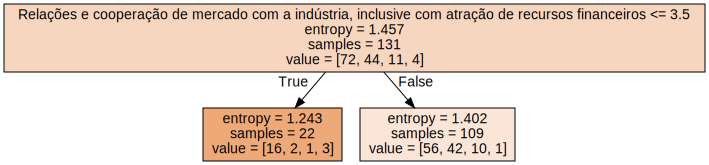

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'balanced_accuracy'

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.522756
mean_test_balanced_accuracy    0.259276
mean_test_f1_micro             0.522756
mean_test_f1_macro             0.220076
mean_test_precision_micro      0.522756
mean_test_recall_micro         0.522756
mean_test_precision_macro      0.206444
mean_test_recall_macro         0.259276
Name: 20, dtype: object

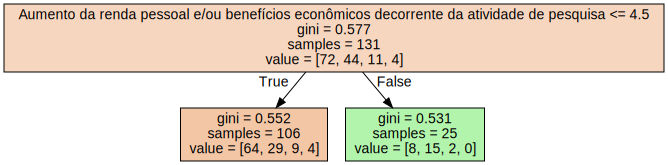

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'f1_micro'

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.530498
mean_test_balanced_accuracy    0.252254
mean_test_f1_micro             0.530498
mean_test_f1_macro             0.194537
mean_test_precision_micro      0.530498
mean_test_recall_micro         0.530498
mean_test_precision_macro      0.163294
mean_test_recall_macro         0.252254
Name: 270, dtype: object

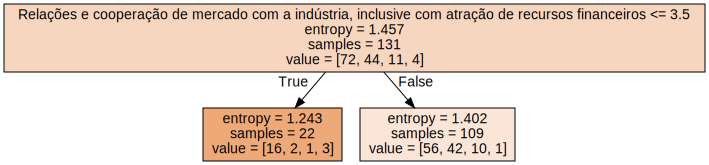

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'f1_macro'

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

mean_test_accuracy             0.461352
mean_test_balanced_accuracy    0.259083
mean_test_f1_micro             0.461352
mean_test_f1_macro             0.248804
mean_test_precision_micro      0.461352
mean_test_recall_micro         0.461352
mean_test_precision_macro      0.251721
mean_test_recall_macro         0.259083
Name: 493, dtype: object

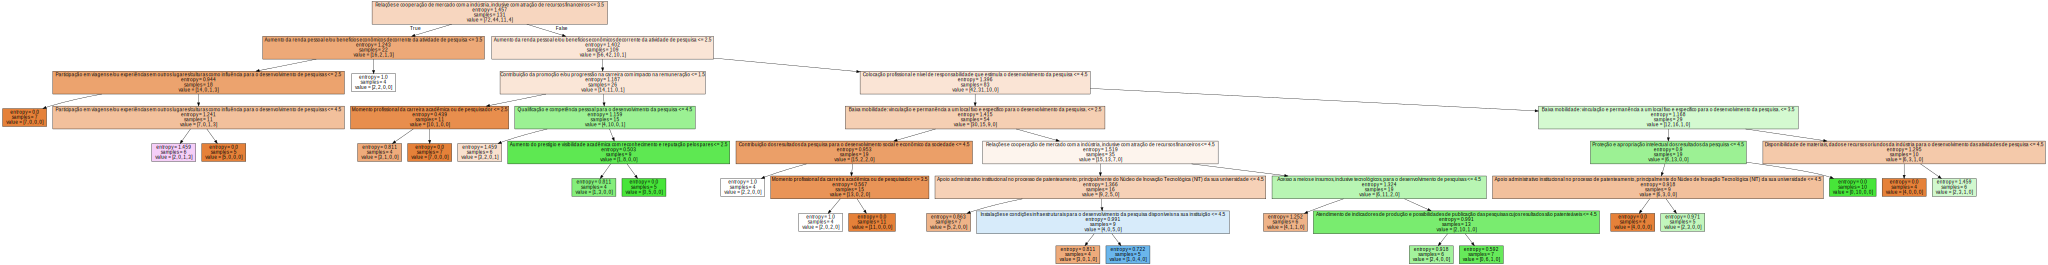

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'precision_micro'

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.530498
mean_test_balanced_accuracy    0.252254
mean_test_f1_micro             0.530498
mean_test_f1_macro             0.194537
mean_test_precision_micro      0.530498
mean_test_recall_micro         0.530498
mean_test_precision_macro      0.163294
mean_test_recall_macro         0.252254
Name: 270, dtype: object

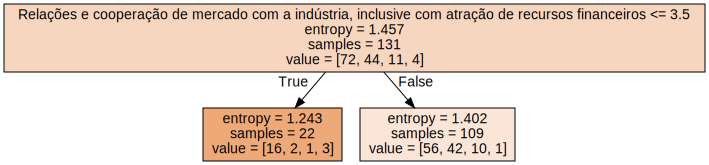

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'recall_micro'

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.530498
mean_test_balanced_accuracy    0.252254
mean_test_f1_micro             0.530498
mean_test_f1_macro             0.194537
mean_test_precision_micro      0.530498
mean_test_recall_micro         0.530498
mean_test_precision_macro      0.163294
mean_test_recall_macro         0.252254
Name: 270, dtype: object

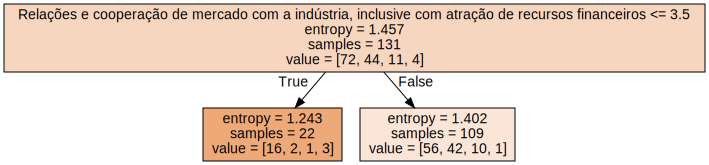

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'precision_macro'

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

mean_test_accuracy             0.461352
mean_test_balanced_accuracy    0.259083
mean_test_f1_micro             0.461352
mean_test_f1_macro             0.248804
mean_test_precision_micro      0.461352
mean_test_recall_micro         0.461352
mean_test_precision_macro      0.251721
mean_test_recall_macro         0.259083
Name: 493, dtype: object

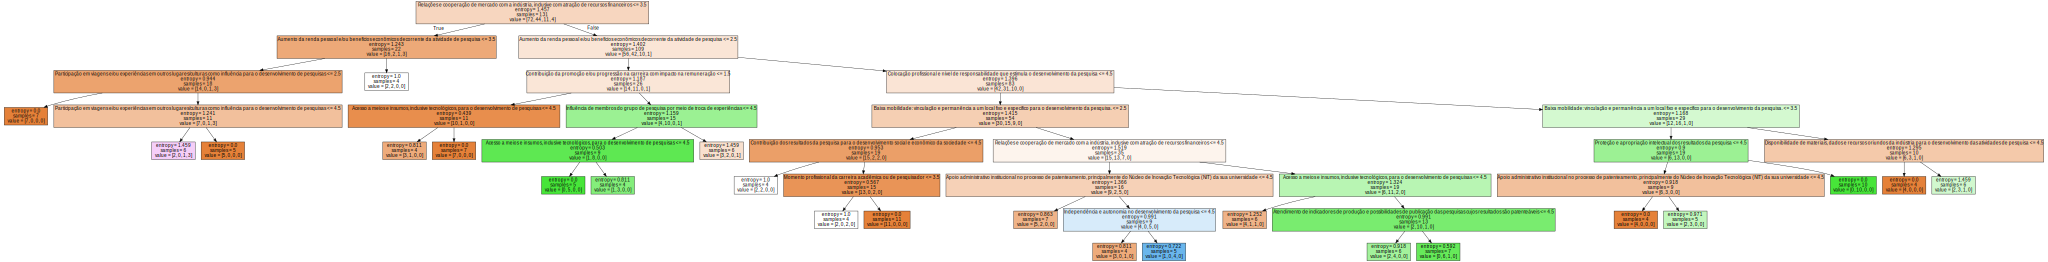

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1_micro',
 'mean_test_f1_macro',
 'mean_test_precision_micro',
 'mean_test_recall_micro',
 'mean_test_precision_macro',
 'mean_test_recall_macro']

'recall_macro'

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

mean_test_accuracy             0.522756
mean_test_balanced_accuracy    0.259276
mean_test_f1_micro             0.522756
mean_test_f1_macro             0.220076
mean_test_precision_micro      0.522756
mean_test_recall_micro         0.522756
mean_test_precision_macro      0.206444
mean_test_recall_macro         0.259276
Name: 20, dtype: object

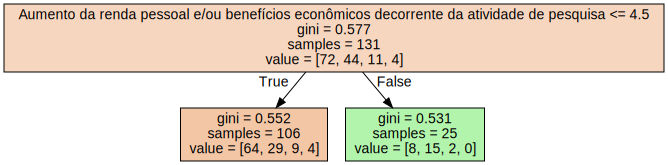

'\n\ndtc = DecisionTreeClassifier(**grid.best_params_).fit(X, y)\ndisplay(plot_tree(dtc, X.columns))\nplotar_feature_im(dtc)\n\n'

In [ ]:
#pd.DataFrame(grid.cv_results_).sort_values('rank_test_f1_macro')[['params', 'mean_test_f1_macro']]

for so in scoring_opts:
    idxmax = df_cv_results[f'mean_test_{so}'].idxmax()
    params = df_cv_results.loc[idxmax].params 
    dtc = sktree.DecisionTreeClassifier(**params).fit(X, y)

    display([f'mean_test_{so}' for so in scoring_opts])
    display(so,params, df_cv_results.loc[idxmax][[f'mean_test_{so}' for so in scoring_opts]])
    display(plot_tree(dtc, X.columns))
    #plotar_feature_im(dtc)
    #plt.show()

    yy = dtc.predict(X) #yy eh o nosso target
    #print(skmetrics.classification_report(y, yy, y.unique()))
    #display(pd.DataFrame(skmetrics.confusion_matrix(y, yy), index=y.unique(), columns=y.unique()))

'''

dtc = DecisionTreeClassifier(**grid.best_params_).fit(X, y)
display(plot_tree(dtc, X.columns))
plotar_feature_im(dtc)

'''

Plotando usando a biblioteca dtreeviz:

In [ ]:
y.value_counts()

Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.                                                72
Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.                                         44
Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.    11
Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.                                                         4
Name: Identifique qual das seguintes afirmações melhor descreve sua orientação profissional., dtype: int64

In [ ]:
len(yy)

131

In [ ]:
#y = pd.to_numeric(y.value_counts())

In [ ]:
X

,"Acesso a meios e insumos, inclusive tecnológicos, para o desenvolvimento de pesquisas","Apoio administrativo institucional no processo de patenteamento, principalmente do Núcleo de Inovação Tecnológica (NIT) da sua universidade",Atendimento de indicadores de produção e possibilidades de publicação das pesquisas cujos resultados são patenteáveis,Aumento da renda pessoal e/ou benefícios econômicos decorrente da atividade de pesquisa,Aumento do prestígio e visibilidade acadêmica com reconhecimento e reputação pelos pares,Baixa mobilidade: vinculação e permanência a um local fixo e específico para o desenvolvimento da pesquisa.,Colocação profissional e nível de responsabilidade que estimula o desenvolvimento da pesquisa,Competição e colaboração entre os pares na formação de redes pessoais e profissionais,Contribuição da promoção e/ou progressão na carreira com impacto na remuneração,Contribuição dos resultados da pesquisa para o desenvolvimento social e econômico da sociedade,"Disponibilidade de materiais, dados e recursos oriundos da indústria para o desenvolvimento das atividades de pesquisa",Experiência profissional anterior como acadêmico e pesquisador,"Gosto por desafios, resolução de problemas de pesquisa e curiosidade intelectual",Habilidade para finanças e realização de negócios,Independência e autonomia no desenvolvimento da pesquisa,Influência de colaboradores e parceiros estrangeiros,Influência de membros do grupo de pesquisa por meio de troca de experiências,Instalações e condições infraestruturais para o desenvolvimento da pesquisa disponíveis na sua instituição,Licenciamento e Comercialização dos resultados da pesquisa,Momento profissional da carreira acadêmica ou de pesquisador,Obtenção de financiamentos e recursos para a pesquisa,Participação em viagens e/ou experiências em outros lugares/culturas como influência para o desenvolvimento de pesquisas,Potencial de aplicação dos resultados da pesquisa,Proteção e apropriação intelectual dos resultados da pesquisa,Qualificação e competência pessoal para o desenvolvimento da pesquisa,"Relações e cooperação de mercado com a indústria, inclusive com atração de recursos financeiros",Satisfação pessoal e realização profissional na realização da pesquisa
0,5,5,5,5,5,5,5,1,5,5,5,5,5,1,5,2,3,5,5,5,5,5,5,5,3,5,5
1,5,4,5,5,3,3,3,2,3,5,5,5,5,5,5,4,4,5,4,4,5,5,5,5,5,5,5
2,4,5,4,3,4,4,4,4,4,4,4,5,5,3,5,4,4,5,4,4,5,5,4,4,4,4,5
3,5,5,4,3,4,4,4,2,3,5,4,4,5,3,4,3,4,5,3,3,4,2,3,3,4,3,4
4,5,5,5,5,5,3,5,3,5,5,5,3,5,5,5,5,5,5,5,4,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,5,4,4,2,3,3,3,3,3,5,3,4,3,3,4,4,4,4,4,4,5,3,5,4,4,5,3
127,1,1,3,1,3,3,5,1,1,5,1,5,5,1,5,1,1,1,1,3,1,1,5,4,5,1,5
128,5,4,4,3,4,3,4,3,3,4,3,4,4,3,5,3,4,4,4,5,5,3,4,4,5,4,4
129,5,5,5,4,4,4,5,4,4,5,5,4,5,4,5,5,5,5,5,4,5,5,5,5,5,5,5


In [ ]:
y[0]


'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.'

In [ ]:
dtc

DecisionTreeClassifier(max_depth=1, min_samples_leaf=5)

In [ ]:
len(y)

131

In [ ]:
#preciso de uma funcao que converta a lista yy pra um dicionario
#y_data needs to consists only of numerical data

#dict_labels_alvo= {'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.':1,
 #                  'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.':2,
  #                 'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.':3,
   #                'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.':
    #               }


In [ ]:
dtc

DecisionTreeClassifier(max_depth=1, min_samples_leaf=5)

In [ ]:
type(y)

pandas.core.series.Series

In [ ]:
yy[0]
#fazer uma estrutura que associe a classe com o numero em y

'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.'

In [ ]:
y.value_counts()

Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.                                                72
Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.                                         44
Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos  para apoiar a pesquisa acadêmica.    11
Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.                                                         4
Name: Identifique qual das seguintes afirmações melhor descreve sua orientação profissional., dtype: int64

In [ ]:
yy_dicio = {'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.':72,
            'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.':44,
            'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.':11,
            'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.':4}

In [ ]:
yy_dicio['Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.']

72

In [ ]:
type(yy)

numpy.ndarray

In [ ]:
labels_alvo = ['Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.',
                            'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.',
                            'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.',
                            'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.']

In [ ]:
labels_alvo

['Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.',
 'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.',
 'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.',
 'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.']

In [ ]:
classifier = dtc
classifier.fit(X,yy)
viz = dtreeviz(classifier,
               X,
               yy_dicio, 
               target_name = 'orientação profissional',
               class_names = ['Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.',
                            'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.',
                            'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.',
                            'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.'],
               histtype = 'barstacked')
viz.view()


AttributeError: ignored

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


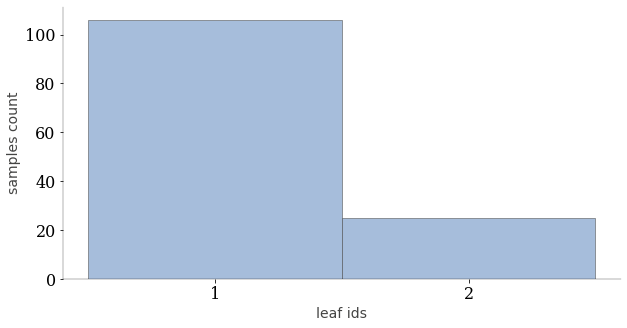

In [ ]:
# eh importante também olharmos as amostras até as folhas.
#podemos ter uma folha com uma boa pureza mas com poucas amostras, oq seria um sinal de overfitting
viz_leaf_samples(dtc, X, y)

In [ ]:
dtc

DecisionTreeClassifier(max_depth=1, min_samples_leaf=5)

In [ ]:
print(labels_alvo)

['Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas a indústria visando ao avanço científico.', 'Acredito na importância da colaboração da academia-indústria e busco desenvolver atividades vinculadas à indústria visando ao aproveitamento comercial.', 'Acredito que a universidade e a indústria devem ser distintas, mas busco desenvolver atividades ligadas à indústria principalmente para adquirir recursos para apoiar a pesquisa acadêmica.', 'Acredito que a universidade e a indústria devem ser distintas. Assim, busco atuar e avançar profissionalmente apenas no campo acadêmico.']


In [ ]:
clas = dtc
viz = dtreeviz(clas,X,y1,target_name= 'orientação profissional',
               class_names = list(labels_alvo))
viz.view()

NameError: ignored

In [ ]:
df_cv_results.params

In [ ]:
print(params)

In [ ]:
print(dtc)

In [ ]:
reptextual = tree.export_text(dtc, feature_names=list(X.columns),show_weights= True)

criterios = []
#auxrules1

#print("\n".join(reptextual.split("\n")[:5])) #o join concatena os elementos da lista usando o \n
#print('-'*105)
for linha in reptextual.split("\n"):
  
  #print("Linha:",linha)
  
  nivel = linha.count("|")
  pos_3tracos = linha.find("---") #p saber de fato qnd pegar exatamente a string
  #print("pos 3 traços:",pos_3tracos,"nivel:",nivel)
  criterios = criterios[:nivel - 1]

  #O +4 eh pra pular os tres tracos e o espaço pra dps pegar a string
  linha = linha[pos_3tracos + 4:] #info do no atual
  
  #se tiver eh pq eh uma folha e se sim posso mostrar a regra completa 
  if "weights" == linha[:len("weights")]: #eu to verificando na linha onde to na string o iniciozinho da string pq tem o weights
    print("\n".join(criterios))
    pos_class = linha.find("class:") #pos do class na string
    print("Classe:",linha[pos_class + 7:])
    weights = eval(linha[9:pos_class - 1]) #transforma a string weights em inteiro mesmo.
    
    l = np.argmax(weights)
    #IMPORTANTE : O ARGMAX RETORNA O INDICE, por isso fiz o weights[l]
    print(weights)
    print("proba: ",np.round(100*weights[l]/np.sum(weights),decimals = 2),"%")
    print("\n")
  else:
    criterios.append(linha) 
  #encontrar a posicao onde ta o class
  #fazer um i.findclass
  #i.find("---")
  #consultar manuais da classe string
  #i.count("|") achar o numero de vzs q ocorre "|" 
  
  #UTIL : eval -> pega uma string e interpreta como codigo python




In [ ]:
yy = sktree.DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 3}).fit(X, y).predict(X)


print(skmetrics.accuracy_score(y, yy), skmetrics.balanced_accuracy_score(y, yy), skmetrics.f1_score(y, yy, average='micro'), skmetrics.f1_score(y, yy, average='macro'))

pd.DataFrame(skmetrics.confusion_matrix(y, yy), index=y.unique(), columns=y.unique())

# Mapa de calor dos atributos numéricos

In [ ]:
plt.figure(figsize = (30,20))
sns.heatmap(df_numericos.corr(),annot = True)
plt.savefig("Correlação dados.png")